In [ ]:
!pip install qiskit

In [ ]:
import math
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.circuit.library import GroverOperator
import numpy as np
from qiskit.quantum_info.operators import Operator
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pickle
from itertools import product,accumulate
import datetime,time
from tqdm import tqdm
from qiskit.visualization import plot_histogram
import functools

No Error Correction

In [ ]:
class QuantumExperiment:
    def __init__(self):
        self.numQubits = 1
        self.noiseInfo = dict()

        self.exp_history = {}
        self.exp_counter = 0

    def tossCoin(self,noiseType = 'bit'):
        probFlip = self.noiseInfo[f'{noiseType}flip']
        return np.random.rand() < probFlip

    def log_exp(self,result_dict):
        self.exp_history[self.exp_counter] = result_dict

    def setNumQubits(self,numQubits):
        self.numQubits = numQubits

    def noiseInfuser(self):
        noise = QuantumCircuit(self.numQubits)

        for i in range(self.numQubits):
            if self.tossCoin('bit'):
                noise.x(i)

            if self.tossCoin('phase'):
                noise.z(i)

        return noise

    def setNoiseInfo(self,noiseInfo = dict()):
        self.noiseInfo = noiseInfo

    def getNoiseInfo(self):
        return self.noiseInfo

def genNoiseDict(bitflip = 0.01, phaseflip = 0.01):
    return {'bitflip':bitflip, 'phaseflip':phaseflip}

In [ ]:
class Grovers(QuantumExperiment):
    def __init__(self,numQubits = 1, noiseInfo=dict()):
       super().__init__() 
       self.setNumQubits(numQubits)
       self.setNoiseInfo(noiseInfo)

    def getDiffuser(self):
        N = self.numQubits
        diffuser = QuantumCircuit(N)
        psi = np.ones(2**N)/np.sqrt(2**N)
        psi_psi = 2*np.outer(psi,psi) - np.identity(2**N)
        psi_psi = Operator(psi_psi.tolist())
        diffuser.unitary(psi_psi,list(range(N)),'diffuser')

        return diffuser

    def getOracle(self,key):
        oracle = QuantumCircuit(self.numQubits)
        oracle_matrix = np.identity(2**(self.numQubits),dtype=int)
        search_key = int(key,2)
        oracle_matrix[search_key,search_key] = -1
        oracle_matrix = Operator(oracle_matrix.tolist())
        oracle.unitary(oracle_matrix,list(range(self.numQubits)),'oracle')
        return oracle

        
    def search(self, key, testMultiple = True): 
        assert len(key) == self.numQubits , "invalid key length"

        self.exp_counter += 1
        
        N = self.numQubits
        # Creating a uniform superposition.
        qubits = [i for i in range(N)]
        grover = QuantumCircuit(N)
        grover.h(qubits)

        oracle = self.getOracle(key)
        diffuser = self.getDiffuser()
        
        # Running U_oracle over the qubits and running the diffuser O(sqrt(N)) times. 
        for _ in range(2*math.ceil(math.sqrt(2**N))):
            grover = grover.compose(oracle)
            if self.noiseInfo != {}: 
                grover = grover.compose(self.noiseInfuser())
            grover = grover.compose(diffuser)
            if self.noiseInfo != {}: 
                grover = grover.compose(self.noiseInfuser())

            if testMultiple == False:
                break
        

        grover.measure_all()
        
        sim = Aer.get_backend('aer_simulator')
        results = transpile(grover, sim)
        distribution = sim.run(results).result().get_counts()
        
        self.log_exp({'numQubits':self.numQubits,
                      'noiseInfo':self.noiseInfo,
                      'searchKey':key,
                      'iterateSearch':testMultiple,
                      'results':distribution})
        
        return grover,distribution

In [ ]:
grovers = Grovers()

In [ ]:
grovers.setNumQubits(3)
grovers.setNoiseInfo(genNoiseDict(0.5,0.5))
circuit, results = grovers.search('000',testMultiple = False)

In [ ]:
circuit.draw()

┌───┐┌─────────┐          ┌───────────┐┌───┐┌───┐ ░ ┌─┐      
   q_0: ┤ H ├┤0        ├──────────┤0          ├┤ X ├┤ Z ├─░─┤M├──────
        ├───┤│         │┌───┐┌───┐│           │└───┘└───┘ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 oracle ├┤ X ├┤ Z ├┤1 diffuser ├───────────░──╫─┤M├───
        ├───┤│         │├───┤└───┘│           │┌───┐      ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2        ├┤ Z ├─────┤2          ├┤ Z ├──────░──╫──╫─┤M├
        └───┘└─────────┘└───┘     └───────────┘└───┘      ░  ║  ║ └╥┘
meas: 3/═════════════════════════════════════════════════════╩══╩══╩═
                                                             0  1  2

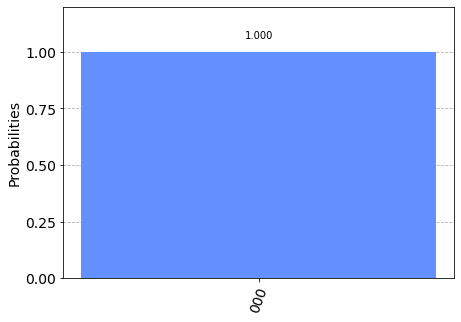

In [ ]:
plot_histogram(results) #0,0

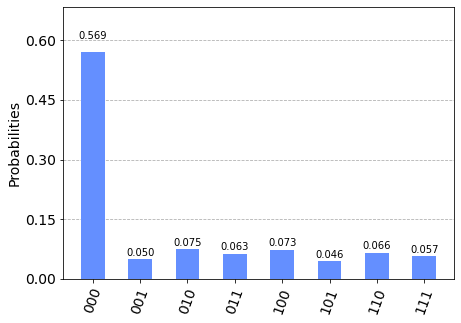

In [ ]:
plot_histogram(results) # 0.05,0.05

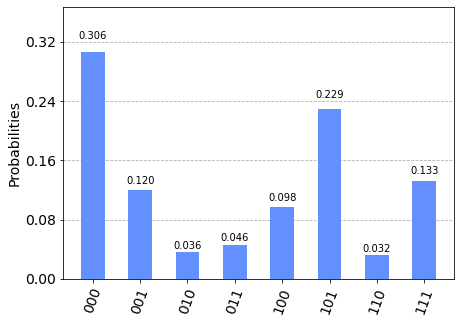

In [ ]:
plot_histogram(results) #0.5,0.5

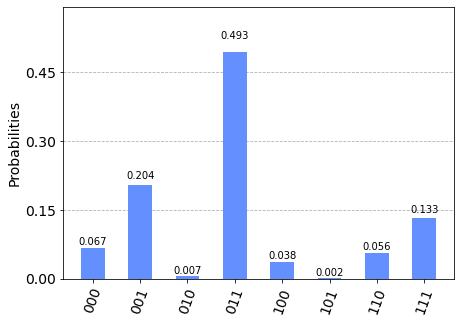

In [ ]:
plot_histogram(results) #0.5,0.5 (2)

In [ ]:
grovers.exp_history

{1: {'iterateSearch': True,
  'noiseInfo': {'bitflip': 0.1, 'phaseflip': 0.1},
  'numQubits': 5,
  'results': {'00000': 23,
   '00001': 2,
   '00010': 30,
   '00011': 6,
   '00100': 28,
   '00110': 19,
   '01000': 5,
   '01001': 41,
   '01010': 12,
   '01011': 39,
   '01100': 46,
   '01101': 114,
   '01110': 52,
   '01111': 120,
   '10000': 25,
   '10001': 48,
   '10010': 25,
   '10011': 57,
   '10100': 39,
   '10101': 93,
   '10110': 33,
   '10111': 52,
   '11000': 38,
   '11001': 5,
   '11010': 46,
   '11011': 10,
   '11100': 8,
   '11110': 8},
  'searchKey': '10111'},
 2: {'iterateSearch': True,
  'noiseInfo': {'bitflip': 0.2, 'phaseflip': 0.2},
  'numQubits': 5,
  'results': {'00000': 66,
   '00001': 2,
   '00010': 60,
   '00011': 10,
   '00100': 22,
   '00101': 41,
   '00110': 27,
   '00111': 82,
   '01001': 96,
   '01010': 41,
   '01100': 18,
   '01101': 44,
   '01110': 82,
   '01111': 41,
   '10000': 9,
   '10001': 29,
   '10010': 131,
   '10011': 12,
   '10100': 2,
   '10101': 

Variable Allocation

In [ ]:
class VAQuantumExperiment:
    def __init__(self):
        self.numQubits = 1
        #self.numActualQubits = 1
        self.code_distances = []
        self.defaultProbFlip = 0.01
        self.error = False
        self.uniform = False


        self.exp_history = {}
        self.exp_counter = 0

        #self.logicalQubitRanges = []

        #self.getAQIPLQ = lambda d: 2*d**2 - 1
        # get Actual Qubit Index Per Logical Qubit

    #def getActualQubitIndex(self, logicalQubitIndex, localIndex):
    #    return sum([self.getAQIPLQ(self.code_distances[i]) for i in range(logicalQubitIndex)]) + localIndex

    def tossCoin(self,probFlip):
        if not self.error:
            return False
        probFlip = self.defaultProbFlip if probFlip is None else probFlip
        return np.random.rand() < probFlip

    def errorize(self,wantWhat = False):
        self.error = wantWhat

    def uniformize(self,wantWhat = False, isroundup=True):
        self.uniform = wantWhat
        if self.uniform:
            totalQubits = sum([2*d**2 - 1 for d in self.code_distances])
            perQubit = totalQubits/self.numQubits
            rounder = math.ceil if isroundup else math.floor
            self.code_distances = [rounder(math.sqrt((perQubit + 1)/2))]*self.numQubits
        else:
            self.code_distances = list(range(1,self.numQubits+1))


    def setCodeDistances(self, codeDistances = None ):
        if codeDistances is None:
            codeDistances = list(range(1,self.numQubits+1))
        assert(self.numQubits == len(codeDistances)) , "invalid number of Qubits assumed in physical qubit allocation"
        self.code_distances = codeDistances \
                if not (codeDistances == []) \
                else [1]*self.numQubits

        #print('test1')
        #self.numActualQubits = sum([self.getAQIPLQ(i) for i in self.code_distances])
        #print('test2')

        #start = 0
        #for cd in self.code_distances:
        #    print(cd)
        #    self.logicalQubitRanges.append((start,start+cd))
        #    start+=cd

    def getErrorProb(self,logical_qubit_index, gamma = 2):
        if logical_qubit_index is None:
            return self.defaultProbFlip
        return (1/gamma)**((1 + self.code_distances[logical_qubit_index])/2)

    def log_exp(self,result_dict):
        self.exp_counter += 1 
        self.exp_history[self.exp_counter] = result_dict

    def setNumQubits(self,numQubits):
        self.numQubits = numQubits

    def noiseInfuser(self):
        noise = QuantumCircuit(self.numQubits)

        for i in range(self.numQubits):
            probFlip = self.getErrorProb(i)
            if self.tossCoin(probFlip):
                noise.x(i)
            if self.tossCoin(probFlip):
                noise.z(i)

        return noise

    def setNoiseInfo(self,noiseInfo = dict()):
        self.noiseInfo = noiseInfo

    def getNoiseInfo(self):
        return self.noiseInfo


In [ ]:
class VAQuantumSearch(VAQuantumExperiment):
    def __init__(self,
                 numQubits = 1,
                 codeDistances = [1]):

       super().__init__() 

       self.setNumQubits(numQubits)
       self.setCodeDistances(codeDistances)

    def getDiffuser(self):
        N = self.numQubits
        diffuser = QuantumCircuit(N)
        psi = np.ones(2**N)/np.sqrt(2**N)
        psi_psi = 2*np.outer(psi,psi) - np.identity(2**N)
        psi_psi = Operator(psi_psi.tolist())
        diffuser.unitary(psi_psi,list(range(N)),'diffuser')

        return diffuser

    def getOracle(self,key):
        oracle = QuantumCircuit(self.numQubits)
        oracle_matrix = np.identity(2**(self.numQubits),dtype=int)
        search_key = int(key,2)
        oracle_matrix[search_key,search_key] = -1
        oracle_matrix = Operator(oracle_matrix.tolist())
        oracle.unitary(oracle_matrix,list(range(self.numQubits)),'oracle')
        return oracle

#    def encodeKey(self, originalKey):
#        key = ''
#        for i,c in enumerate(originalKey):
#            key += c*self.getAQIPLQ(self.code_distances[i])
#        return key

#    def decodeEncodedQubit(self,encodedQubit):
#        ones = encodedQubit.count('1')
#        if ones < len(encodedQubit) - ones:
#            return '0'
#        else:
#            return '1'
#
#    def decodeKey(self,encodedKey):
#        key = ''
#        for rng in self.logicalQubitRanges:
#            encodedQubit = encodedKey[rng[0]:rng[1]]
#            key+= self.decodeEncodedQubit(encodedQubit)
#
#    def decodeDist(self,distribution):
#        decodedDist = {}
#        for key,value in distribution:
#            decodedKey = self.decodeKey(key)
#            if decodedKey in decodedDist.keys():
#                decodedDist[decodedKey] += value
#            else:
#                decodedDist[decodedKey] = value
        
    def search(self, key = None, testMultiple = True): 
        if key is None:
            key = '0'*self.numQubits
        assert len(key) == self.numQubits , "invalid key length"

        N = self.numQubits
        # Creating a uniform superposition.
        qubits = [i for i in range(N)]
        grover = QuantumCircuit(N)
        grover.h(qubits)

        oracle = self.getOracle(key)

        diffuser = self.getDiffuser()

        # Running U_oracle over the qubits and running the diffuser O(sqrt(N)) times. 
        for _ in range(2*math.ceil(math.sqrt(2**N))):
            grover = grover.compose(oracle)
            grover = grover.compose(self.noiseInfuser())

            grover = grover.compose(diffuser)
            grover = grover.compose(self.noiseInfuser())

            if testMultiple == False:
                break
        
        grover.measure_all()
        
        sim = Aer.get_backend('aer_simulator')
        results = transpile(grover, sim)
        distribution = sim.run(results).result().get_counts()
        
        log_dict =   {'numQubits':self.numQubits,
                      'codeDistances':self.code_distances,
                      'searchKey':key,
                      'results': distribution,
                      'errorized': self.error,
                      'expValue': self.calcExpValue(distribution),
                      'uniform_alloc': self.uniform,
                      'iterateSearch':testMultiple}

        #self.log_exp(log_dict)
        
        return grover, distribution, log_dict

    def calcExpValue(self,dist):
        total = sum(dist.values()) 
        Nr =  sum([int(key,2)*dist[key] for key in dist.keys()])
        return Nr/total

In [ ]:
vagrovers = VAQuantumSearch()

In [ ]:
vagrovers.setNumQubits(5)
vagrovers.setCodeDistances()
vagrovers.uniformize(True)

In [ ]:
vagrovers.errorize(True)
vagrovers.search('11111')

(<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fbd3c122890>,
 {'00000': 3,
  '00001': 3,
  '00010': 2,
  '00011': 48,
  '00100': 88,
  '00101': 55,
  '00111': 2,
  '01000': 23,
  '01001': 60,
  '01010': 17,
  '01011': 2,
  '01100': 21,
  '01101': 4,
  '01110': 55,
  '01111': 98,
  '10000': 49,
  '10001': 6,
  '10011': 7,
  '10100': 57,
  '10101': 20,
  '10110': 40,
  '10111': 26,
  '11010': 40,
  '11011': 2,
  '11100': 34,
  '11101': 1,
  '11110': 258,
  '11111': 3})

In [ ]:
class Experimenter:
    def __init__(self,savedir, expName):
        self.expName = expName
        self.logs = pd.DataFrame(columns = ['NumQubits','NumRuns','TimeTakenPerRunMean',
                                            'TimeTakenPerRunStd','AllocationStrat','Errorized',
                                            'ExpValueMean','ExpValueStd'])
        self.savedir = Path(savedir)
        self.checkpoint_ctr = 0

    def log(self, numQubits, numRuns, timeTakenPerRunMean, timeTakenPerRunStd, allocationStrat, errorized, expValueMean, expValueStd):
        self.logs.loc[len(self.logs.index)] = [numQubits,numRuns, timeTakenPerRunMean, timeTakenPerRunStd, allocationStrat, errorized, expValueMean, expValueStd]

    def backup(self):
        self.logs.to_pickle(self.savedir/f'{self.expName}_{self.checkpoint_ctr}_{datetime.datetime.now()}.pkl')
        self.checkpoint_ctr += 1 

In [ ]:
paramNumQubits = [2,4,6,8]
paramAllocationStrat = ['uni_ceil','uni_floor','var']
paramNumRuns = [128, 256, 512]

expName = "Noisy_Grovers_Search"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
savedir = Path(f'/content/drive/MyDrive/QuantumErrorCorr')
savedir.mkdir(exist_ok=True)

In [ ]:
vagrovers = VAQuantumSearch()
#vagrovers.setNumQubits()
#vagrovers.setCodeDistances()
#vagrovers.uniformize()
#vagrovers.errorize()
#vagrovers.search()

In [ ]:
experimenter = Experimenter(expName,savedir)

In [ ]:
ctr = 1
total_scenarios = len(paramAllocationStrat)*len(paramNumQubits)*len(paramNumRuns)
backup_every = len(paramNumQubits)

for numQubits, allocationStrat, numRuns in product(paramNumQubits,paramAllocationStrat,paramNumRuns):
    vagrovers.setNumQubits(numQubits)
    vagrovers.setCodeDistances()
    if allocationStrat == 'var':
        vagrovers.uniformize(wantWhat = False)
    elif allocationStrat == 'uni_ceil':
        vagrovers.uniformize(wantWhat = True, isroundup = True)
    else:
        vagrovers.uniformize(wantWhat = True, isroundup = False)

    
    print(f'Initializing : {numQubits} : {allocationStrat} : {numRuns}')

    ## Error Free Version
    durations = []
    expValues = []

    vagrovers.errorize(False)
    for i in tqdm(list(range(numRuns))):
        start = time.time()
        _,_,results = vagrovers.search()
        end = time.time()
        durations.append(end-start)
        expValues.append(results['expValue'])

    experimenter.log(numQubits, numRuns, np.mean(durations),np.std(durations),allocationStrat, 'False',np.mean(expValues),np.std(expValues))

    
    ## Errorized Version
    durations = []
    expValues = []

    vagrovers.errorize(True)
    for i in tqdm(list(range(numRuns))):
        start = time.time()
        _,_,results = vagrovers.search()
        end = time.time()
        durations.append(end-start)
        expValues.append(results['expValue'])

    experimenter.log(numQubits, numRuns, np.mean(durations),np.std(durations),allocationStrat, 'True',np.mean(expValues),np.std(expValues))
    
    print(f'Finished : {numQubits} : {allocationStrat} : {numRuns}')

    ctr+=1
    if ctr % backup_every ==0:
        experimenter.backup()




Initializing : 2 : uni_ceil : 128


100%|██████████| 128/128 [00:06<00:00, 21.11it/s]


Finished : 2 : uni_ceil : 128
Initializing : 2 : uni_ceil : 256


100%|██████████| 256/256 [00:11<00:00, 21.53it/s]


Finished : 2 : uni_ceil : 256
Initializing : 2 : uni_ceil : 512


100%|██████████| 512/512 [00:23<00:00, 21.53it/s]


Finished : 2 : uni_ceil : 512
Initializing : 2 : uni_floor : 128


100%|██████████| 128/128 [00:07<00:00, 17.28it/s]


Finished : 2 : uni_floor : 128
Initializing : 2 : uni_floor : 256


100%|██████████| 256/256 [00:15<00:00, 16.69it/s]


Finished : 2 : uni_floor : 256
Initializing : 2 : uni_floor : 512


100%|██████████| 512/512 [00:30<00:00, 16.75it/s]


Finished : 2 : uni_floor : 512
Initializing : 2 : var : 128


100%|██████████| 128/128 [00:06<00:00, 19.19it/s]


Finished : 2 : var : 128
Initializing : 2 : var : 256


100%|██████████| 256/256 [00:13<00:00, 18.50it/s]


Finished : 2 : var : 256
Initializing : 2 : var : 512


100%|██████████| 512/512 [00:26<00:00, 19.19it/s]


Finished : 2 : var : 512
Initializing : 4 : uni_ceil : 128


100%|██████████| 128/128 [00:14<00:00,  8.83it/s]


Finished : 4 : uni_ceil : 128
Initializing : 4 : uni_ceil : 256


100%|██████████| 256/256 [00:29<00:00,  8.59it/s]


Finished : 4 : uni_ceil : 256
Initializing : 4 : uni_ceil : 512


100%|██████████| 512/512 [00:59<00:00,  8.56it/s]


Finished : 4 : uni_ceil : 512
Initializing : 4 : uni_floor : 128


100%|██████████| 128/128 [00:19<00:00,  6.65it/s]


Finished : 4 : uni_floor : 128
Initializing : 4 : uni_floor : 256


100%|██████████| 256/256 [00:38<00:00,  6.70it/s]


Finished : 4 : uni_floor : 256
Initializing : 4 : uni_floor : 512


100%|██████████| 512/512 [01:18<00:00,  6.52it/s]


Finished : 4 : uni_floor : 512
Initializing : 4 : var : 128


100%|██████████| 128/128 [00:17<00:00,  7.19it/s]


Finished : 4 : var : 128
Initializing : 4 : var : 256


100%|██████████| 256/256 [00:35<00:00,  7.14it/s]


Finished : 4 : var : 256
Initializing : 4 : var : 512


100%|██████████| 512/512 [01:11<00:00,  7.21it/s]


Finished : 4 : var : 512
Initializing : 6 : uni_ceil : 128


100%|██████████| 128/128 [00:35<00:00,  3.62it/s]


Finished : 6 : uni_ceil : 128
Initializing : 6 : uni_ceil : 256


100%|██████████| 256/256 [01:12<00:00,  3.52it/s]


Finished : 6 : uni_ceil : 256
Initializing : 6 : uni_ceil : 512


100%|██████████| 512/512 [02:25<00:00,  3.53it/s]


Finished : 6 : uni_ceil : 512
Initializing : 6 : uni_floor : 128


100%|██████████| 128/128 [00:45<00:00,  2.83it/s]


Finished : 6 : uni_floor : 128
Initializing : 6 : uni_floor : 256


100%|██████████| 256/256 [01:30<00:00,  2.82it/s]


Finished : 6 : uni_floor : 256
Initializing : 6 : uni_floor : 512


100%|██████████| 512/512 [03:00<00:00,  2.83it/s]


Finished : 6 : uni_floor : 512
Initializing : 6 : var : 128


100%|██████████| 128/128 [00:43<00:00,  2.97it/s]


Finished : 6 : var : 128
Initializing : 6 : var : 256


100%|██████████| 256/256 [01:26<00:00,  2.96it/s]


Finished : 6 : var : 256
Initializing : 6 : var : 512


100%|██████████| 512/512 [02:52<00:00,  2.97it/s]


Finished : 6 : var : 512
Initializing : 8 : uni_ceil : 128


100%|██████████| 128/128 [03:44<00:00,  1.75s/it]


Finished : 8 : uni_ceil : 128
Initializing : 8 : uni_ceil : 256


100%|██████████| 256/256 [07:29<00:00,  1.76s/it]


Finished : 8 : uni_ceil : 256
Initializing : 8 : uni_ceil : 512


100%|██████████| 512/512 [14:59<00:00,  1.76s/it]


Finished : 8 : uni_ceil : 512
Initializing : 8 : uni_floor : 128


100%|██████████| 128/128 [04:00<00:00,  1.88s/it]


Finished : 8 : uni_floor : 128
Initializing : 8 : uni_floor : 256


100%|██████████| 256/256 [07:58<00:00,  1.87s/it]


Finished : 8 : uni_floor : 256
Initializing : 8 : uni_floor : 512


100%|██████████| 512/512 [16:01<00:00,  1.88s/it]


Finished : 8 : uni_floor : 512
Initializing : 8 : var : 128


100%|██████████| 128/128 [04:19<00:00,  2.03s/it]


Finished : 8 : var : 128
Initializing : 8 : var : 256


100%|██████████| 256/256 [08:39<00:00,  2.03s/it]


Finished : 8 : var : 256
Initializing : 8 : var : 512


100%|██████████| 512/512 [17:31<00:00,  2.05s/it]

Finished : 8 : var : 512
